## Installations

You can install using Google-Colab

In [ ]:
!pip install Fitter
!pip install river
!pip install PyLaTeX
!sudo apt-get install latexmk
!sudo apt-get install -y texlive-latex-extra
!pip install pdflatex

## Imports

In [1]:
# import loaders and logics
import sys
sys.path.append('./scripts')
from datadriftloader import DataDriftLoader
from featurestoblame import FeaturesToBlame
from predictions import PredictDistribution
from reportproducer import createReport

import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# constants
DISTRIBUTIONS_OPTIONS=('cauchy', 'chi2', 'expon', 'exponpow', 'gamma', 'lognorm', 'norm', 'powerlaw', 'rayleigh', 'uniform', 'burr', 'beta', 'alpha', 'logistic', 'loggamma', 'pareto', 'gengamma', 'genhalflogistic', 'lomax', 'pearson3')
DATA_PATH = "./data/AAP.csv"
COLUMNS_TO_REMOVE = ['Date']
EPOCHS = 200

### Loading the dataset

In [2]:
# load one CSV file for each dataset we used.
# split each of them to drifts.
# create dataset-class for each. 

dataDriftLoader = DataDriftLoader(data_path=DATA_PATH, distributions=DISTRIBUTIONS_OPTIONS)
# remove non-numeric columns
dataDriftLoader.removeColumns(l_columns=COLUMNS_TO_REMOVE)
# detect derifts in data
dataDriftLoader.findDrifts()

# split dataset to drifts- before and after
before, after = dataDriftLoader.splitForFTB()

# prepare dataset to prediction
trainData = dataDriftLoader.splitForPrediction()

# save test data
testData = dataDriftLoader.getTestData()

## Features to blame

### Histograms Visualization for Before & After drift

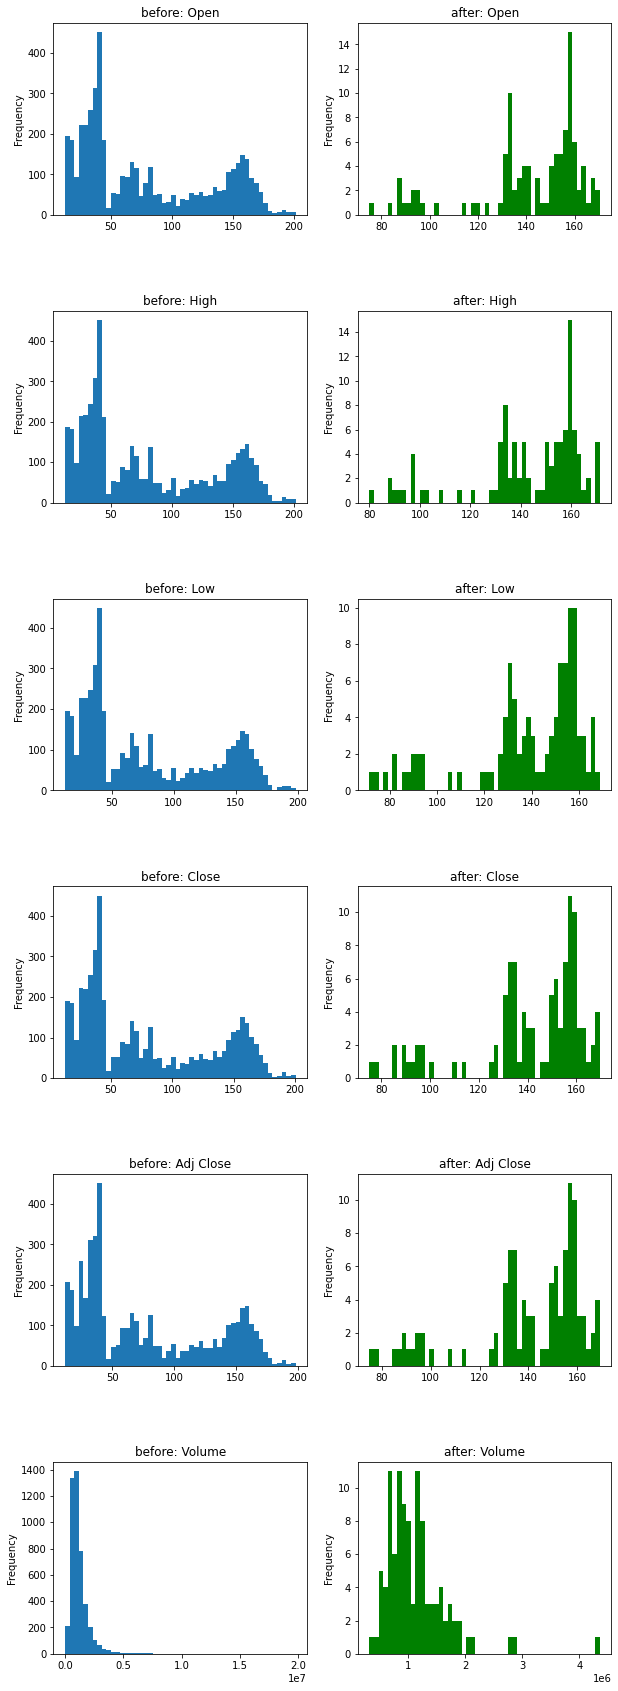

In [3]:
# we will create a histogram for each feature
cols = 2
rows = len(before.columns)

# generate a figures grid:
fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
fig.subplots_adjust(hspace=0.5)

for i, column in enumerate(before.columns):   
    # plot a histogram chart using Pandas
    before[column].plot(kind='hist', ax=axes[i, 0], title='before: ' + column, bins=50)
    after[column].plot(kind='hist', ax=axes[i, 1], title='after: ' + column, color=['green'], bins=50)

### Estimate the distribution

Thanks to Rahul Raoniar's [paper](https://medium.com/the-researchers-guide/finding-the-best-distribution-that-fits-your-data-using-pythons-fitter-library-319a5a0972e9) about it.

In [4]:
featuresToBlame = FeaturesToBlame(before, after, distributions=DISTRIBUTIONS_OPTIONS)
# find out the feature to blame
# prints the distributions for each feature
featuresToBlame.compareDistribution()
# show results
# print a table with the results- up to one row for each feature.
featuresToBlame_results, results = featuresToBlame.getFeaturesToBlame()
results.head()

** Features to Blame **
We found 5 features to blame:


,Feature,Before,After
0,Open,gamma,burr
1,High,lognorm,loggamma
2,Low,burr,loggamma
3,Close,gamma,loggamma
4,Adj Close,gamma,burr


## Predict next distribution

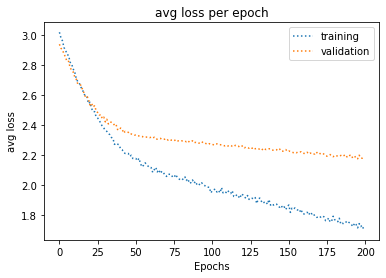

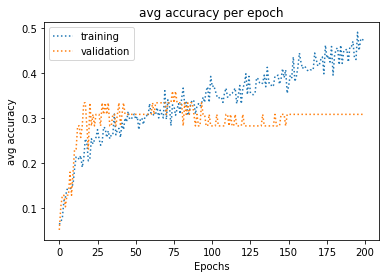

** Predict Feature Distributions **


,Feature,Current,Prediction
0,Open,cauchy,gamma
1,High,beta,lognorm
2,Low,beta,burr
3,Close,beta,gamma
4,Adj Close,beta,gamma


In [5]:
# init the model with given dataset.
predictDistribution = PredictDistribution(trainData, testData ,distributions=DISTRIBUTIONS_OPTIONS)
# (train the model in backstage)
# show the graphs comparing training and validation.
predictDistribution.train(EPOCHS)
# predict and print the next distributions for each feature
predictions_results, results = predictDistribution.predict()
results.head()

## Results

In [6]:
# use the results of the two sections and create a report with it.
createReport(featuresToBlame_results, predictions_results)